In [199]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import ElasticNet
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('data/pre_post_features_2019_2020.csv')

In [3]:
df.head()

,member_id,days_pre,elg_days_pre,tc_pre,care_attdpcs_tc_pre,care_cls_tc_pre,care_aclf_tc_pre,care_alfgc_tc_pre,care_adult_day_tc_pre,hcbs_tc_pre,icf_tc_pre,ip_tc_pre,rx_tc_pre,dme_tc_pre,ed_tc_pre,snf_tc_pre,out_tc_pre,pro_tc_pre,amb_tc_pre,hh_tc_pre,hosp_tc_pre,oth_tc_pre,hcbs_respite_tc_pre,hcbs_adult_comp_care_tc_pre,hcbs_com_trans_tc_pre,hcbs_educ_train_tc_pre,hcbs_com_trans_waiv_tc_pre,hcbs_home_meal_tc_pre,hcbs_ther_behav_tc_pre,hcbs_waiv_svc_tc_pre,hcbs_attd_tc_pre,hcbs_pcs_tc_pre,hcbs_pers_tc_pre,hcbs_assist_tech_tc_pre,oxygen_tc_pre,hosp_bed_tc_pre,pcp_ddos_pre,chf_ddos_pre,heart_ddos_pre,copd_ddos_pre,pulmonar_ddos_pre,cancer_ddos_pre,ckd_ddos_pre,esrd_ddos_pre,lipidy_ddos_pre,diab_ddos_pre,alzh_ddos_pre,demented_ddos_pre,stroke_ddos_pre,hyper_ddos_pre,fall_ddos_pre,trans_ddos_pre,liver_ddos_pre,hippy_ddos_pre,depressed_ddos_pre,psycho_ddos_pre,drugy_ddos_pre,pressure_ulcer_ddos_pre,boozy_ddos_pre,paralyzed_ddos_pre,paral_mono_ddos_pre,paral_mono_dom_ddos_pre,paral_hemi_ddos_pre,paral_hemi_dom_ddos_pre,paral_para_ddos_pre,paral_quad_ddos_pre,tbi_ddos_pre,obese_ddos_pre,bh_ddos_pre,bh_hemophilia_pre,chf_tc_pre,heart_tc_pre,copd_tc_pre,pulmonar_tc_pre,cancer_tc_pre,ckd_tc_pre,esrd_tc_pre,lipidy_tc_pre,diab_tc_pre,alzh_tc_pre,demented_tc_pre,stroke_tc_pre,hyper_tc_pre,fall_tc_pre,trans_tc_pre,liver_tc_pre,hippy_tc_pre,depressed_tc_pre,psycho_tc_pre,druggy_tc_pre,boozy_tc_pre,paralyzed_tc_pre,mono_tc_pre,mono_dom_tc_pre,hemi_tc_pre,hemi_dom_tc_pre,para_tc_pre,quad_tc_pre,tbi_tc_pre,obese_tc_pre,pressure_ulcer_tc_pre,hh_aide_tc_pre,medical_tc_pre,nrx_tc_pre,navi_tc_pre,hemophilia_tc_pre,days_post,elg_days_post,tc_post,care_attdpcs_tc_post,care_cls_tc_post,care_aclf_tc_post,care_alfgc_tc_post,care_adult_day_tc_post,hcbs_tc_post,icf_tc_post,ip_tc_post,rx_tc_post,dme_tc_post,ed_tc_post,snf_tc_post,out_tc_post,pro_tc_post,amb_tc_post,hh_tc_post,hosp_tc_post,oth_tc_post,hcbs_respite_tc_post,hcbs_adult_comp_care_tc_post,hcbs_com_trans_tc_post,hcbs_educ_train_tc_post,hcbs_com_trans_waiv_tc_post,hcbs_home_meal_tc_post,hcbs_ther_behav_tc_post,hcbs_waiv_svc_tc_post,hcbs_attd_tc_post,hcbs_pcs_tc_post,hcbs_pers_tc_post,hcbs_assist_tech_tc_post,oxygen_tc_post,hosp_bed_tc_post,pcp_ddos_post,chf_ddos_post,heart_ddos_post,copd_ddos_post,pulmonar_ddos_post,cancer_ddos_post,ckd_ddos_post,esrd_ddos_post,lipidy_ddos_post,diab_ddos_post,alzh_ddos_post,demented_ddos_post,stroke_ddos_post,hyper_ddos_post,fall_ddos_post,trans_ddos_post,liver_ddos_post,hippy_ddos_post,depressed_ddos_post,psycho_ddos_post,drugy_ddos_post,pressure_ulcer_ddos_post,boozy_ddos_post,paralyzed_ddos_post,paral_mono_ddos_post,paral_mono_dom_ddos_post,paral_hemi_ddos_post,paral_hemi_dom_ddos_post,paral_para_ddos_post,paral_quad_ddos_post,tbi_ddos_post,obese_ddos_post,bh_ddos_post,bh_hemophilia_post,chf_tc_post,heart_tc_post,copd_tc_post,pulmonar_tc_post,cancer_tc_post,ckd_tc_post,esrd_tc_post,lipidy_tc_post,diab_tc_post,alzh_tc_post,demented_tc_post,stroke_tc_post,hyper_tc_post,fall_tc_post,trans_tc_post,liver_tc_post,hippy_tc_post,depressed_tc_post,psycho_tc_post,druggy_tc_post,boozy_tc_post,paralyzed_tc_post,mono_tc_post,mono_dom_tc_post,hemi_tc_post,hemi_dom_tc_post,para_tc_post,quad_tc_post,tbi_tc_post,obese_tc_post,pressure_ulcer_tc_post,hh_aide_tc_post,medical_tc_post,nrx_tc_post,navi_tc_post,hemophilia_tc_post
0,21009,365,365,44478.23,261.63,0.0,0.0,0.0,0.0,0.00,0.0,14414.43,217.73,346.78,2780.88,7000.0,621.17,17171.13,1250.56,413.92,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,261.63,0.0,0.0,0.0,0.0,1,0,1,0,0,19,0,0,3,0,0,0,0,3,1,0,0,0,0,0,0,0,0,4,4,0,0,0,0,0,0,2,2,0,0.0,323.77,0.00,0.0,32526.93,0.0,0.0,6879.31,0.00,0.0,0.0,0.0,9166.96,2608.27,0.0,0.0,0.0,0.00,0.00,0.0,0.0,347.68,347.68,0.0,0.0,0.0,0.00,0.0,0.0,2817.34,0.00,0.0,43652.09,44260.50,7484.05,0.0,366,366,171005.18,16728.44,0.0,0.0,0.0,0.0,1434.45,0.0,0.00,31191.55,1341.09,950.00,0.0,426.73,116778.64,750.36,1403.92,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6952.67,9775.77,0.0,0.0,0.00,0.0,0,0,0,0,0,30,0,0

In [4]:
target_cols = ['ip_tc', 'ed_tc', 'snf_tc', 'amb_tc']


In [37]:
pre_target_cols = [tc + '_pre' for tc in target_cols]
post_target_cols = [tc + '_post' for tc in target_cols]

df = df.assign(target_pre=lambda x: x[pre_target_cols].sum(axis=1),
               target_post=lambda x: x[post_target_cols].sum(axis=1))

df[pre_target_cols + ['target_pre'] + post_target_cols + ['target_post']].head()

,ip_tc_pre,ed_tc_pre,snf_tc_pre,amb_tc_pre,target_pre,ip_tc_post,ed_tc_post,snf_tc_post,amb_tc_post,target_post
0,14414.43,2780.88,7000.0,1250.56,25445.87,0.00,950.00,0.0,750.36,1700.36
1,0.00,97.94,0.0,0.00,97.94,0.00,0.00,0.0,0.00,0.00
2,0.00,810.10,0.0,436.31,1246.41,6322.01,406.03,0.0,798.93,7526.97
3,0.00,6013.62,0.0,1991.88,8005.50,17879.20,10427.72,0.0,4725.49,33032.41
4,0.00,720.97,0.0,0.00,720.97,0.00,0.00,0.0,0.00,0.00


### Create base case model to compare to
Objective is to flag high risk members, specifically top 20%
Base case benchmnark uses the pre targets to sort and take the top 20%

In [121]:
def riskiest_grp_accuracy(pred, actual):
    n = pred.shape[0]
    top_n = int(n*.2)
    middle_n = int(n*.4)
    bottom_n = n - top_n - middle_n
    top_n, middle_n, bottom_n
    
    overlap = set(pred[:top_n].member_id) & set(actual[:top_n].member_id)
    n_overlap = len(overlap)
    overlap_pct = n_overlap / top_n
    print(f'Total n: {n}, Top n: {top_n}, Overlap: n: {n_overlap}, pct: {overlap_pct}')
    return overlap, n_overlap, overlap_pct
        

In [122]:
pre_sorted = df.sort_values('target_pre', ascending=False)
post_sorted = df.sort_values('target_post', ascending=False)

riskiest_grp_accuracy(pre_sorted, post_sorted);

Total n: 26371, Top n: 5274, Overlap: n: 2847, pct: 0.5398179749715586


### Train Val Test Split
60 - 20 - 20

In [141]:
train_df, validate_df, test_df = np.split(df.sample(frac=1, random_state=42),
                                 [int(.6*len(df)), int(.8*len(df))])
train_df.shape[0], validate_df.shape[0], test_df.shape[0]

(15822, 5274, 5275)

In [202]:
pre_feature_cols = [c for c in df.columns if '_pre' in c and '_post' not in c]
post_target_col = 'target_post'


def build_xy(df, drop_na=True, scaler_func=None):
    if drop_na:
        df = df[~df.isna().any(axis=1)]
        
    X = df[pre_feature_cols]
    y = df[post_target_col]
    
    if scaler_func is not None:
        X = scaler_func(X)
    
    return X, y, df

### Linear model

In [203]:
X_train, y_train, train  = build_xy(train_df)

In [204]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [205]:
regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train)
regr.score(X_train, y_train)

0.518907172063303

Interpret model predictions on training set

In [206]:
preds = regr.predict(X_train)
train = train.assign(preds=preds)

pre_sorted = train.sort_values('target_pre', ascending=False)
post_sorted = train.sort_values('target_post', ascending=False)

riskiest_grp_accuracy(pre_sorted, post_sorted);

Total n: 12192, Top n: 2438, Overlap: n: 1354, pct: 0.5553732567678425


In [207]:
sorted_preds = train.sort_values('preds', ascending=False)
riskiest_grp_accuracy(sorted_preds, post_sorted);

Total n: 12192, Top n: 2438, Overlap: n: 1357, pct: 0.5566037735849056


6% improvement over raw sorting, indicates model is picking up on at least some signal

#### Validation

In [208]:
X_val, y_val, val = build_xy(validate_df, scaler_func=scaler.transform)
regr.score(X_val, y_val)

0.27874315146439144

In [209]:
preds = regr.predict(X_val)
val = val.assign(preds=preds)

pre_sorted = val.sort_values('target_pre', ascending=False)
post_sorted = val.sort_values('target_post', ascending=False)

_, _, base_overlap_pct = riskiest_grp_accuracy(pre_sorted, post_sorted);

Total n: 4072, Top n: 814, Overlap: n: 457, pct: 0.5614250614250614


In [210]:
sorted_preds = val.sort_values('preds', ascending=False)

_, _, model_overlap_pct = riskiest_grp_accuracy(sorted_preds, post_sorted);

Total n: 4072, Top n: 814, Overlap: n: 450, pct: 0.5528255528255528


In [211]:
print(f'Model improved {(model_overlap_pct / base_overlap_pct - 1) * 100}%')

Model improved -1.5317286652078876%


### Tree based model

In [212]:
# note, can leave in na rows for this model type
X_train, y_train, train  = build_xy(train_df, drop_na=True)

In [213]:
est = HistGradientBoostingRegressor().fit(X_train, y_train)
est.score(X_train, y_train)

0.6818865097394945

In [214]:
preds = est.predict(X_train)
train = train.assign(preds=preds)

pre_sorted = train.sort_values('target_pre', ascending=False)
post_sorted = train.sort_values('target_post', ascending=False)

_, _, base_overlap_pct = riskiest_grp_accuracy(pre_sorted, post_sorted);
sorted_preds = train.sort_values('preds', ascending=False)
_, _, model_overlap_pct = riskiest_grp_accuracy(sorted_preds, post_sorted);
print(f'Model improved {(model_overlap_pct / base_overlap_pct - 1) * 100}%')

Total n: 12192, Top n: 2438, Overlap: n: 1354, pct: 0.5553732567678425
Total n: 12192, Top n: 2438, Overlap: n: 1491, pct: 0.6115668580803938
Model improved 10.118168389955674%


#### Validation

In [215]:
X_val, y_val, val = build_xy(validate_df)
est.score(X_val, y_val)

0.2863257865804728

In [216]:
preds = est.predict(X_val)
val = val.assign(preds=preds)

pre_sorted = val.sort_values('target_pre', ascending=False)
post_sorted = val.sort_values('target_post', ascending=False)

_, _, base_overlap_pct = riskiest_grp_accuracy(pre_sorted, post_sorted);
sorted_preds = val.sort_values('preds', ascending=False)
_, _, model_overlap_pct = riskiest_grp_accuracy(sorted_preds, post_sorted);
print(f'Model improved {(model_overlap_pct / base_overlap_pct - 1) * 100}%')

Total n: 4072, Top n: 814, Overlap: n: 457, pct: 0.5614250614250614
Total n: 4072, Top n: 814, Overlap: n: 455, pct: 0.558968058968059
Model improved -0.4376367614879584%


### Feature Importance

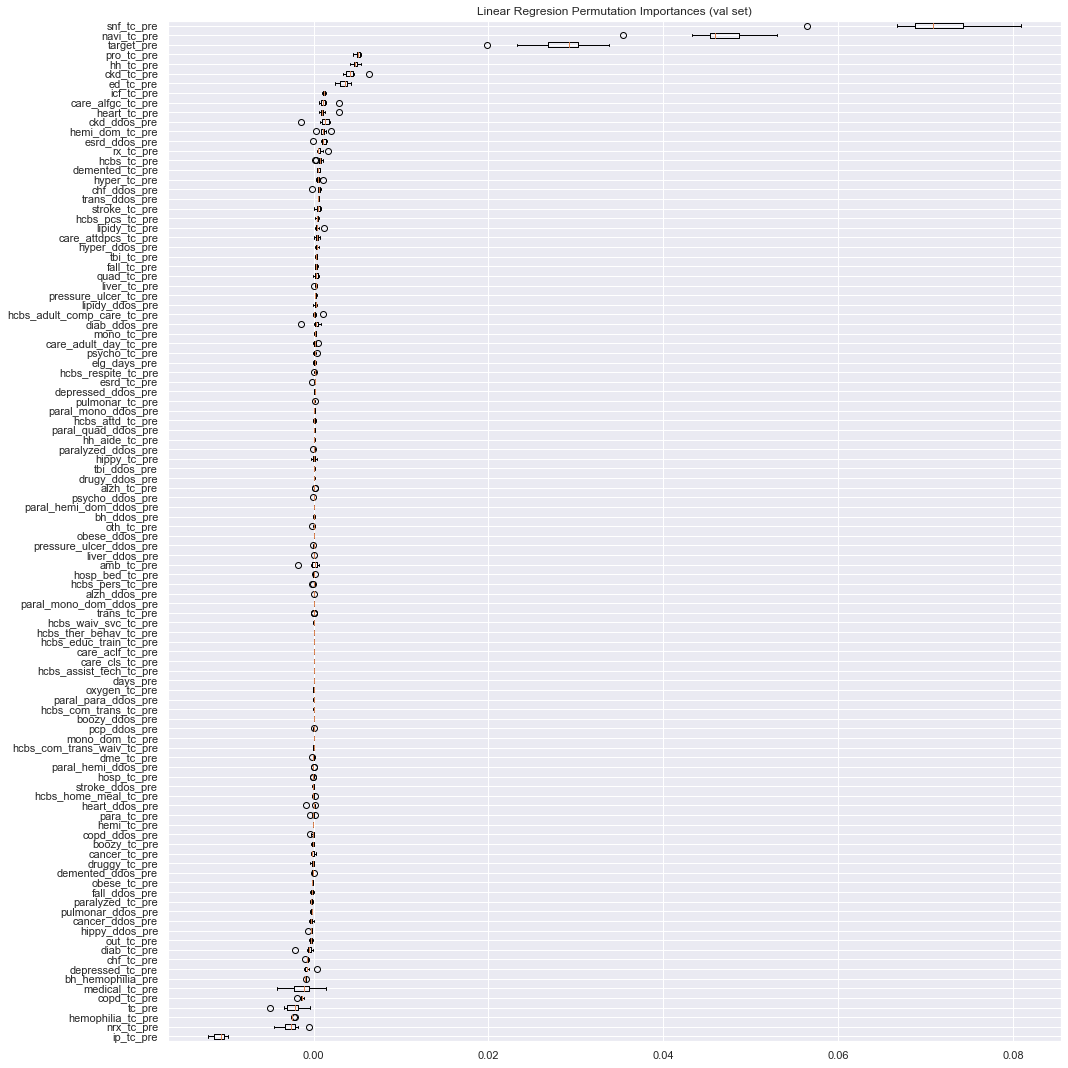

In [220]:
result = permutation_importance(
    regr, scaler.transform(X_val), y_val, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,15))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=val[pre_feature_cols].columns[sorted_idx]
)
ax.set_title("Linear Regresion Permutation Importances (val set)")
fig.tight_layout()
plt.show()

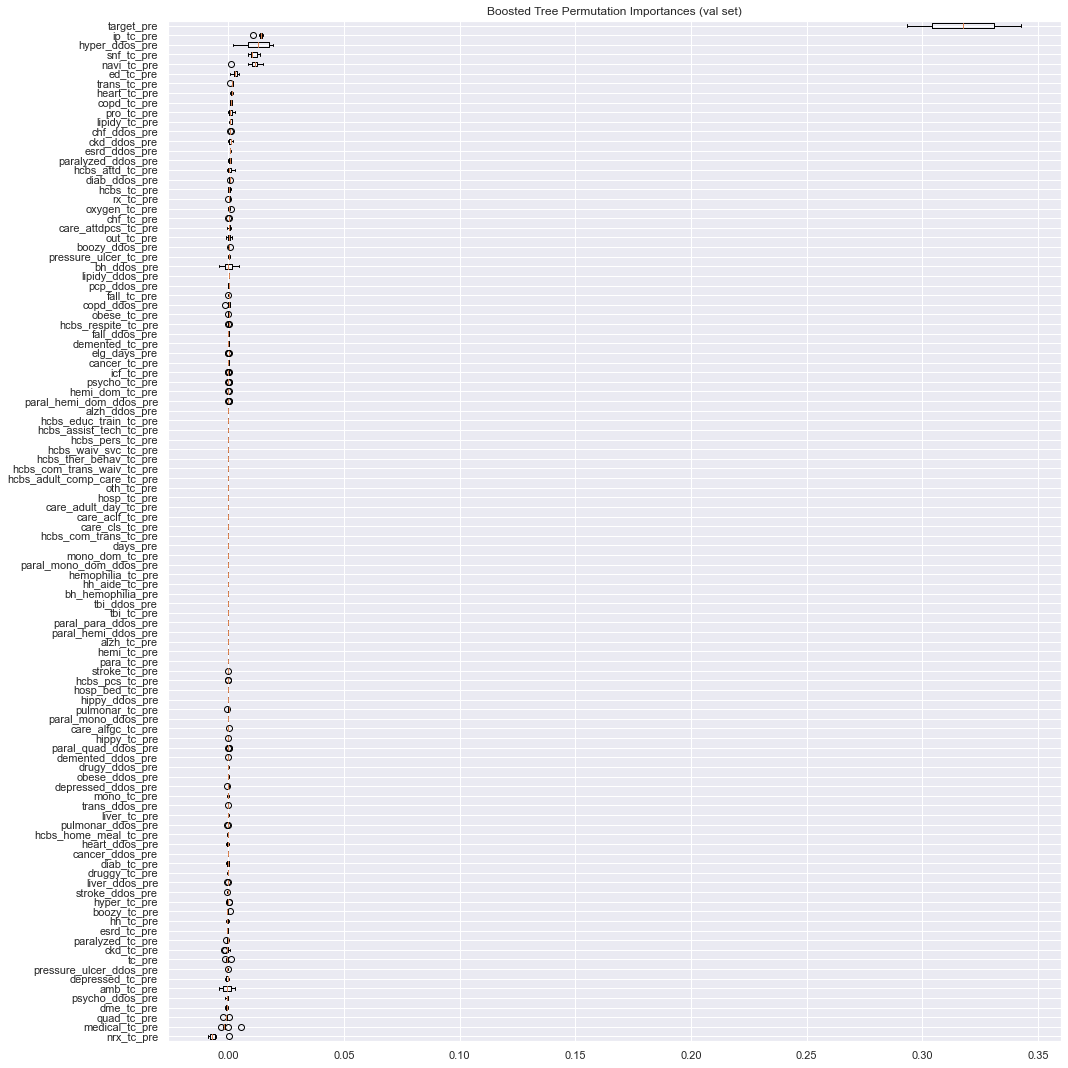

In [221]:
result = permutation_importance(
    est, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,15))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=val[pre_feature_cols].columns[sorted_idx]
)
ax.set_title("Boosted Tree Permutation Importances (val set)")
fig.tight_layout()
plt.show()

#### New Strategy: Fewer features but broken out into smaller time periods
Focus on important features but try brekaing them out quarterly or monthly